# import

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from tensorflow.keras import Model, layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input

In [2]:
# seed hold

random_seed = 42
SEED = 42
np.random.seed(random_seed)
import os
import random

import tensorflow as tf

random.seed(random_seed)


def set_seeds(seed=SEED):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)


def set_global_determinism(seed=SEED, fast_n_close=False):

    set_seeds(seed=seed)
    if fast_n_close:
        return
        logging.warning(
            "*******************************************************************************"
        )
        logging.warning(
            "*** set_global_determinism is called,setting full determinism, will be slow ***"
        )
        logging.warning(
            "*******************************************************************************"
        )
        os.environ["TF_DETERMINISTIC_OPS"] = "1"
        os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
        # https://www.tensorflow.org/api_docs/python/tf/config/threading/set_inter_op_parallelism_threads
        tf.config.threading.set_inter_op_parallelism_threads(1)
        tf.config.threading.set_intra_op_parallelism_threads(1)
        from tfdeterminism import patch

        patch()


set_seeds()
set_global_determinism()

# Make dataset

In [3]:
# read_csv

path = "../dataset/data/Media/"
data1 = pd.read_csv(path + "Media_INFO.csv")
data2 = pd.read_csv(path + "Media_LOGIN.csv")
data3 = pd.read_csv(path + "Media_MENU.csv")
data4 = pd.read_csv(path + "Media_STREAM.csv")

In [4]:
# make all

all_data = pd.merge(data1, data2, on="Timestamp", how="inner")
all_data = pd.merge(all_data, data3, on="Timestamp", how="inner")
all_data = pd.merge(all_data, data4, on="Timestamp", how="inner")

In [5]:
all_data.drop(["Timestamp"], inplace=True, axis=1)

In [6]:
# fillna mean

all_data = all_data.fillna(all_data.mean())

In [7]:
# copy data

train = all_data.copy()
train.shape

(210240, 33)

## Transform to sequence

In [8]:
step = 5

def trans_sequences(df, step):
    temp = []
    for i in range(len(df)-step+1):
        temp.append(df.iloc[i:(i+step)].values)
    
    return np.array(temp)

train_seq = trans_sequences(train, step)

print(f'Training shape: {train_seq.shape}')

Training shape: (210236, 5, 33)


## feature scaling

In [9]:
train_seq_for_scale = train_seq.copy()
train_number = train_seq_for_scale.shape[0]
feature_number = train_seq_for_scale.shape[2]

In [10]:
scaler = StandardScaler()

for i in range(step):
    scaler.partial_fit(train_seq_for_scale[:, i, :])

In [11]:
scaled_array = []

for i in range(step):
    scaled_array.append(scaler.transform(train_seq_for_scale[:, i, :]).reshape(train_number, 1, feature_number))
    
train_scaled = np.concatenate(scaled_array, axis=1)

# modeling

In [12]:
train_ntimepredict = train_scaled[:, 1:, :]
outstep = train_ntimepredict.shape[1]
epochs = 10
batch_size = 256
validation_split = 0.2
earlystop_patience = 2

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-12 16:04:28.537317: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-12 16:04:28.538217: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 33)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 5, 16)        3200        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 5, 16)        0           ['lstm[0][0]']                   
                                                                                                  
 lstm_1 (LSTM)                  (None, 8)            800         ['dropout[0][0]']                
                                                                                              

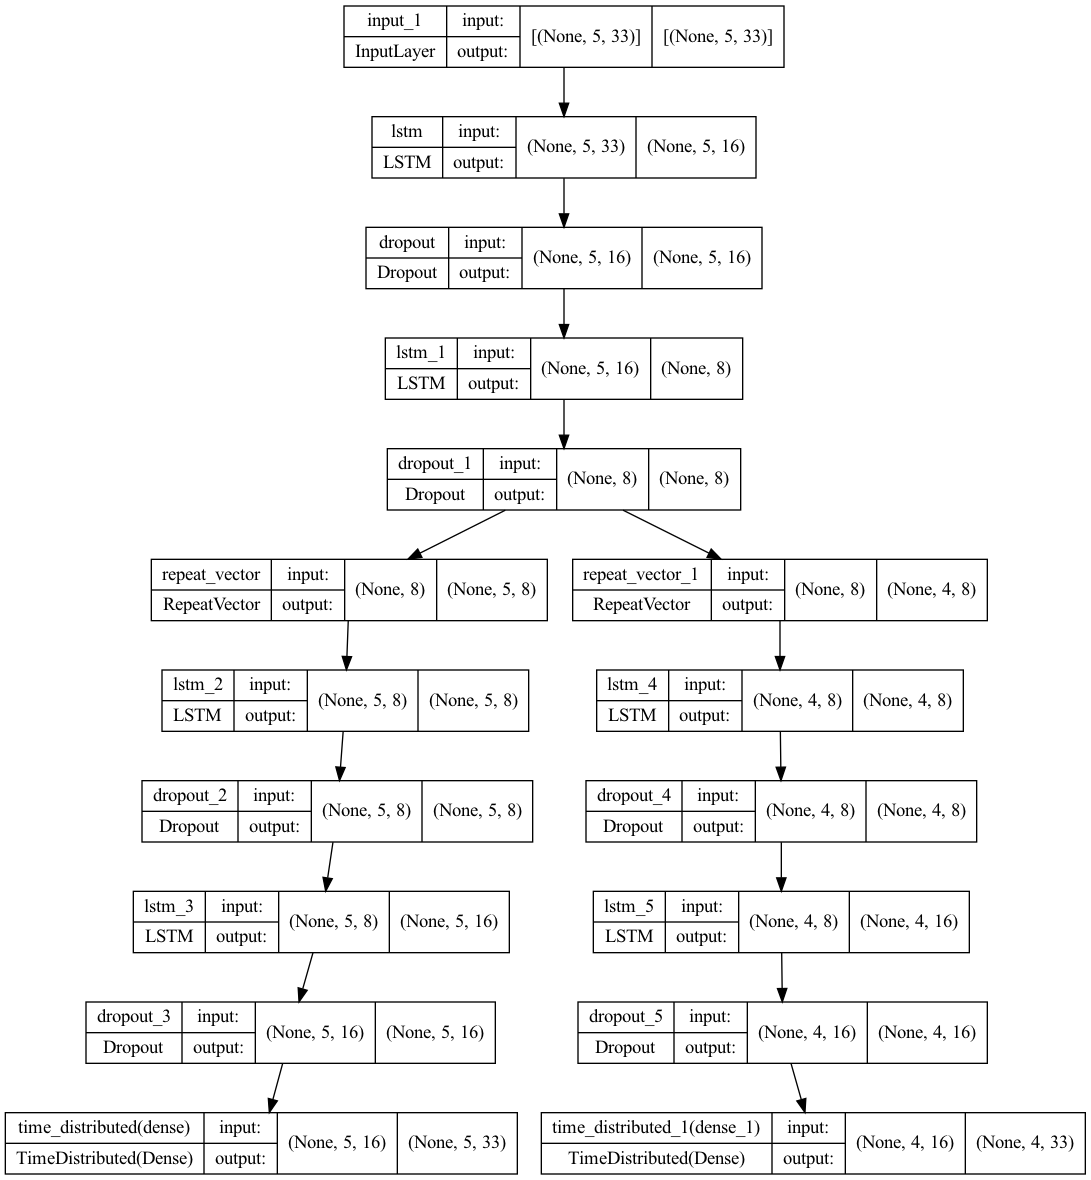

In [13]:
# encoder
pre_input = Input(shape=(step,feature_number))
encoder = LSTM(16, activation='relu', return_sequences=True)(pre_input)
encoder = Dropout(.1)(encoder)
encoder = LSTM(8, activation='relu', return_sequences=False)(encoder)
encoder = Dropout(.1)(encoder)

# reconstruct decoder
decoder1 = RepeatVector(step)(encoder)
decoder1 = LSTM(8, activation='relu', return_sequences=True)(decoder1)
decoder1 = Dropout(.1)(decoder1)
decoder1 = LSTM(16, activation='relu', return_sequences=True)(decoder1)
decoder1 = Dropout(.1)(decoder1)
decoder1 = TimeDistributed(Dense(feature_number))(decoder1)

# predict decoder
decoder2 = RepeatVector(outstep)(encoder)
decoder2 = LSTM(8, activation='relu', return_sequences=True)(decoder2)
decoder2 = Dropout(.1)(decoder2)
decoder2 = LSTM(16, activation='relu', return_sequences=True)(decoder2)
decoder2 = Dropout(.1)(decoder2)
decoder2 = TimeDistributed(Dense(feature_number))(decoder2)

# tie
lstm_autoencoder = Model(inputs=pre_input, outputs=[decoder1, decoder2])
lstm_autoencoder.summary()
lstm_autoencoder.compile(optimizer='adam', loss='mse')
plot_model(lstm_autoencoder, show_shapes=True)

In [14]:
# fit

history = lstm_autoencoder.fit(train_scaled, [train_scaled, train_ntimepredict], epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=earlystop_patience, mode='min')], shuffle=False)

Epoch 1/10


2022-05-12 16:04:30.091558: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-12 16:04:33.506063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


657/657 [==============================] - ETA: 0s - loss: 0.6870 - time_distributed_loss: 0.3239 - time_distributed_1_loss: 0.3631

2022-05-12 16:09:04.090669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


657/657 [==============================] - 280s 417ms/step - loss: 0.6870 - time_distributed_loss: 0.3239 - time_distributed_1_loss: 0.3631 - val_loss: 0.5813 - val_time_distributed_loss: 0.2434 - val_time_distributed_1_loss: 0.3380
Epoch 2/10
657/657 [==============================] - 183s 278ms/step - loss: 0.5389 - time_distributed_loss: 0.2609 - time_distributed_1_loss: 0.2780 - val_loss: 0.4922 - val_time_distributed_loss: 0.2444 - val_time_distributed_1_loss: 0.2478
Epoch 3/10
657/657 [==============================] - 169s 258ms/step - loss: 0.4895 - time_distributed_loss: 0.2484 - time_distributed_1_loss: 0.2411 - val_loss: 0.4604 - val_time_distributed_loss: 0.2288 - val_time_distributed_1_loss: 0.2316
Epoch 4/10
657/657 [==============================] - 166s 253ms/step - loss: 0.4729 - time_distributed_loss: 0.2389 - time_distributed_1_loss: 0.2341 - val_loss: 0.4592 - val_time_distributed_loss: 0.2282 - val_time_distributed_1_loss: 0.2311
Epoch 5/10
657/657 [===============

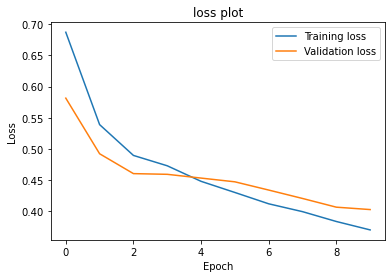

In [15]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right')
plt.title('loss plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Make dataset for train

In [16]:
train_predictions = lstm_autoencoder.predict(train_scaled)

2022-05-12 16:34:46.297292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [18]:
print(train_predictions[0].shape)
print(train_predictions[1].shape)

(210236, 5, 33)
(210236, 4, 33)


In [19]:
reconstruction_train_mse = np.mean(np.mean(np.power(train_scaled - train_predictions[0], 2), axis=1), axis=1)
prediction_train_mse = np.mean(np.mean(np.power(train_scaled[:, 1:, :] - train_predictions[1], 2), axis=1), axis=1)

In [30]:
train_error = list(abs(reconstruction_train_mse + prediction_train_mse) > np.mean(reconstruction_train_mse + prediction_train_mse))
for _ in range(4):
    train_error.insert(0, train_error[0])
train_error = pd.DataFrame(train_error, columns=['Prediction'])
train_error['Prediction'].replace(True, 1, inplace=True)
train_error['Prediction'].replace(False, 0, inplace=True)
print(train_error.value_counts(), len(train_error))

Prediction
0             157302
1              52938
dtype: int64 210240


In [31]:
train_error[train_error['Prediction'] == 1].index

Int64Index([     0,      1,      2,      3,      4,      5,     47,     48,
                49,     50,
            ...
            210230, 210231, 210232, 210233, 210234, 210235, 210236, 210237,
            210238, 210239],
           dtype='int64', length=52938)

# prepare new train

In [64]:
new_train = all_data.drop(train_error[train_error['Prediction'] == 1].index)
new_train_seq = trans_sequences(new_train, step)
print(f'Training shape: {new_train_seq.shape}')
new_train_seq_for_scale = new_train_seq.copy()
new_train_number = new_train_seq_for_scale.shape[0]
scaler = MinMaxScaler()

for i in range(step):
    scaler.partial_fit(new_train_seq_for_scale[:, i, :])

scaled_array = []

for i in range(step):
    scaled_array.append(scaler.transform(new_train_seq_for_scale[:, i, :]).reshape(new_train_number, 1, feature_number))
    
new_train_scaled = np.concatenate(scaled_array, axis=1)

Training shape: (157298, 5, 33)


# Make dataset for test

In [65]:
test = all_data[105120:]
test.reset_index(drop=True, inplace=True)

## Transform to sequence

In [66]:
test_seq = trans_sequences(test, step)

print(f'Training shape: {test_seq.shape}')

Training shape: (105116, 5, 33)


## feature scaling

In [67]:
test_seq_for_scale = test_seq.copy()
test_number = test_seq_for_scale.shape[0]

In [68]:
scaled_array = []

for i in range(step):
    scaled_array.append(scaler.transform(test_seq_for_scale[:, i, :]).reshape(test_number, 1, feature_number))
    
test_scaled = np.concatenate(scaled_array, axis=1)

# model refit

In [69]:
new_train_ntimepredict = new_train_scaled[:, 1:, :]

In [70]:
history = lstm_autoencoder.fit(new_train_scaled, [new_train_scaled, new_train_ntimepredict], epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=earlystop_patience, mode='min')], shuffle=False)

Epoch 1/10
492/492 [==============================] - 113s 229ms/step - loss: 0.0297 - time_distributed_loss: 0.0151 - time_distributed_1_loss: 0.0146 - val_loss: 0.0071 - val_time_distributed_loss: 0.0036 - val_time_distributed_1_loss: 0.0035
Epoch 2/10
492/492 [==============================] - 131s 267ms/step - loss: 0.0157 - time_distributed_loss: 0.0077 - time_distributed_1_loss: 0.0079 - val_loss: 0.0067 - val_time_distributed_loss: 0.0034 - val_time_distributed_1_loss: 0.0033
Epoch 3/10
492/492 [==============================] - 125s 253ms/step - loss: 0.0127 - time_distributed_loss: 0.0063 - time_distributed_1_loss: 0.0064 - val_loss: 0.0065 - val_time_distributed_loss: 0.0033 - val_time_distributed_1_loss: 0.0032
Epoch 4/10
492/492 [==============================] - 127s 258ms/step - loss: 0.0110 - time_distributed_loss: 0.0055 - time_distributed_1_loss: 0.0055 - val_loss: 0.0064 - val_time_distributed_loss: 0.0033 - val_time_distributed_1_loss: 0.0031
Epoch 5/10
492/492 [====

# Predict & anormaly detect

In [71]:
test_predictions = lstm_autoencoder.predict(test_scaled)

In [72]:
print(test_predictions[0].shape)
print(test_predictions[1].shape)

(105116, 5, 33)
(105116, 4, 33)


In [73]:
reconstruction_mse = np.mean(np.mean(np.power(test_scaled - test_predictions[0], 2), axis=1), axis=1)
prediction_mse = np.mean(np.mean(np.power(test_scaled[:, 1:, :] - test_predictions[1], 2), axis=1), axis=1)

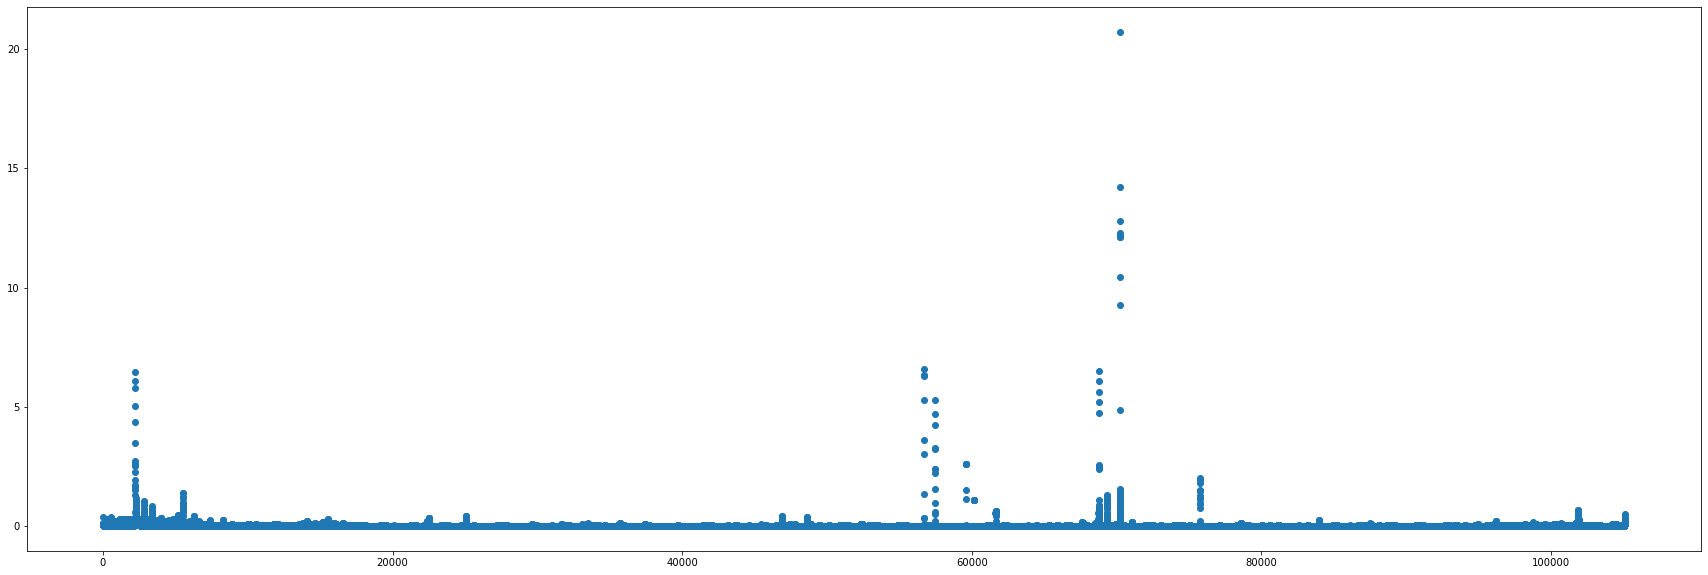

In [263]:
plt.figure(figsize = (30,10))
plt.scatter(pd.DataFrame(reconstruction_mse).index, reconstruction_mse)

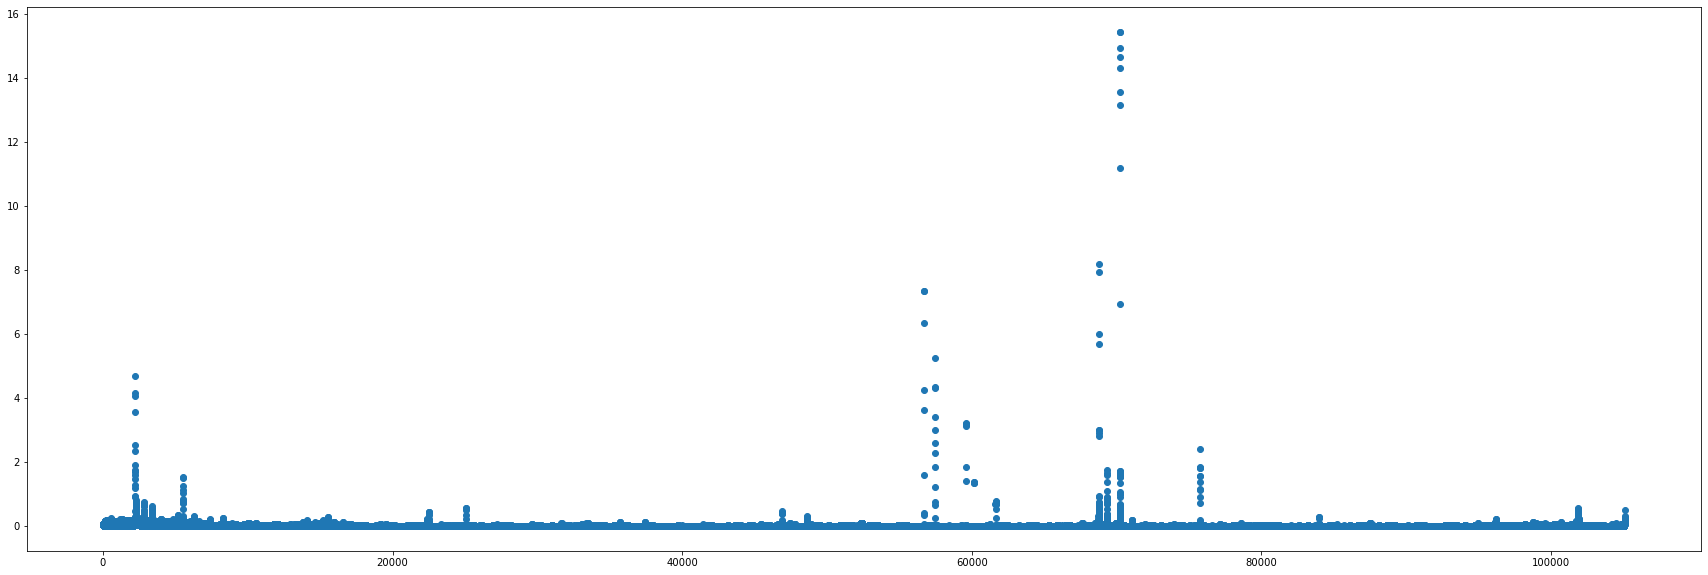

In [262]:
plt.figure(figsize = (30,10))
plt.scatter(pd.DataFrame(prediction_mse).index, prediction_mse)

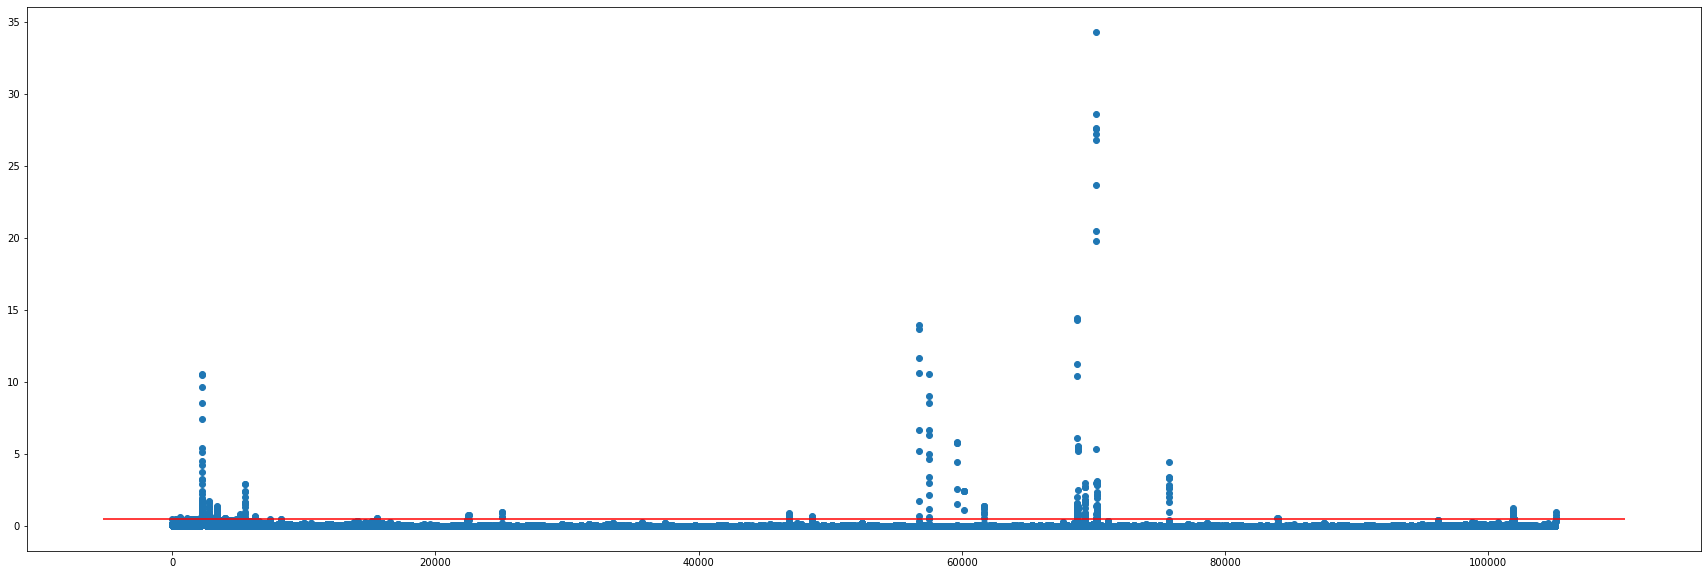

In [283]:
plt.figure(figsize = (30,10))
threshold = 0.5
ax = plt.subplot()
plt.scatter(pd.DataFrame(prediction_mse).index, (prediction_mse+reconstruction_mse))
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

In [284]:
(reconstruction_mse + prediction_mse).mean()

0.02910335924763182

In [285]:
error = list((reconstruction_mse + prediction_mse) > threshold)
for _ in range(4):
    error.insert(0, error[0])
error = pd.DataFrame(error, columns=['Prediction'])
error['Prediction'].replace(True, 1, inplace=True)
error['Prediction'].replace(False, 0, inplace=True)
print(error.value_counts(), len(error))

Prediction
0             104728
1                392
dtype: int64 105120


In [286]:
error.to_csv('error.csv', mode='w')

In [287]:
708*6.5

4602.0

In [288]:
708*6

4248

In [279]:
error[error['Prediction'] == 1]

,Prediction
565,1
566,1
567,1
568,1
1142,1
...,...
105112,1
105116,1
105117,1
105118,1
